In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

def mkdir(route):
    try: os.mkdir(route)
    except Exception as e: print(e)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.compat.v1.enable_eager_execution()

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.4


In [2]:
feature_desc = {
    'x': tf.io.FixedLenFeature([], tf.string),
    'y': tf.io.FixedLenFeature([], tf.string)
}

def parse_example(example_proto):
    res = tf.io.parse_single_example(example_proto, feature_desc)
    x = tf.io.parse_tensor(res['x'], out_type=tf.int64)
    y = tf.io.parse_tensor(res['y'], out_type=tf.int64)
    x.set_shape((16, 16, 3))
    y.set_shape(())
    return x, y

train_val_ds = tf.data.TFRecordDataset("/kaggle/input/daphnet-images/train.tfrecord").map(parse_example).batch(64)
test_ds = tf.data.TFRecordDataset("/kaggle/input/daphnet-images/test.tfrecord").map(parse_example).batch(64)

TRAIN_VAL_BATCHES = 15389
TRAIN_BATCHES = int(TRAIN_VAL_BATCHES * 0.9)

train_ds = train_val_ds.take(TRAIN_BATCHES)
val_ds = train_val_ds.skip(TRAIN_BATCHES).take(TRAIN_VAL_BATCHES - TRAIN_BATCHES)

2023-01-01 14:54:13.609328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 14:54:13.688753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 14:54:13.689549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 14:54:13.692090: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
cnn = keras.Sequential([
    layers.Conv2D(32, kernel_size=3, activation='swish', padding="same", input_shape=(16, 16, 3)),
    layers.Conv2D(56, kernel_size=3, activation="swish", padding="same"),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.25),
    layers.Conv2D(128, kernel_size=3, activation="swish", padding="same"),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(128, kernel_size=3, activation="swish", padding="same"),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1024, activation='swish'),
    layers.Dense(1, activation="sigmoid")
])

cnn.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                      loss=keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy', "Precision", "Recall", "AUC"])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 56)        16184     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 56)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 56)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         64640     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 128)        

In [17]:
history_cnn = cnn.fit(train_ds, validation_data = val_ds, epochs=20)

Epoch 1/20
13850/13850 [==============================] - 166s 12ms/step - loss: 0.2276 - accuracy: 0.9124 - precision: 0.6569 - recall: 0.2837 - auc: 0.8826 - val_loss: 0.1462 - val_accuracy: 0.9404 - val_precision: 0.6901 - val_recall: 0.7337 - val_auc: 0.9655
Epoch 2/20
13850/13850 [==============================] - 159s 11ms/step - loss: 0.1182 - accuracy: 0.9514 - precision: 0.7978 - recall: 0.6972 - auc: 0.9728 - val_loss: 0.0809 - val_accuracy: 0.9690 - val_precision: 0.8003 - val_recall: 0.9196 - val_auc: 0.9922
Epoch 3/20
13850/13850 [==============================] - 159s 11ms/step - loss: 0.0765 - accuracy: 0.9696 - precision: 0.8705 - recall: 0.8225 - auc: 0.9884 - val_loss: 0.0488 - val_accuracy: 0.9818 - val_precision: 0.9036 - val_recall: 0.9160 - val_auc: 0.9960
Epoch 4/20
13850/13850 [==============================] - 160s 12ms/step - loss: 0.0567 - accuracy: 0.9779 - precision: 0.9026 - recall: 0.8765 - auc: 0.9932 - val_loss: 0.0322 - val_accuracy: 0.9886 - val_preci

In [18]:
logs_cnn = pd.DataFrame(history_cnn.history)
logs_cnn

,loss,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc
0,2.276192e-01,0.912357,0.656883,0.283665,0.882576,0.146200,0.940442,0.690110,0.733719,0.965543
1,1.182073e-01,0.951390,0.797812,0.697206,0.972757,0.080914,0.969023,0.800283,0.919638,0.992209
2,7.650518e-02,0.969605,0.870520,0.822530,0.988412,0.048810,0.981830,0.903588,0.915981,0.995999
3,5.666283e-02,0.977885,0.902562,0.876479,0.993186,0.032200,0.988564,0.926509,0.961902,0.998473
4,3.210858e+10,0.981444,0.917838,0.897288,0.994943,0.033947,0.988056,0.908628,0.978970,0.998724
5,3.885328e-02,0.985229,0.934239,0.918988,0.996469,0.026857,0.990209,0.922287,0.985066,0.999151
6,3.454713e-02,0.986791,0.939928,0.929092,0.997181,0.018906,0.993276,0.957085,0.976532,0.999151
7,3.218086e-02,0.987772,0.944524,0.934255,0.997423,0.028730,0.989376,0.909658,0.992279,0.999370
8,2.931482e-02,0.988995,0.949883,0.941099,0.997663,0.026082,0.990565,0.918576,0.993701,0.999502
9,2.920042e-02,0.988890,0.949477,0.940454,0.997811,0.026698,0.990219,0.915886,0.993396,0.999461


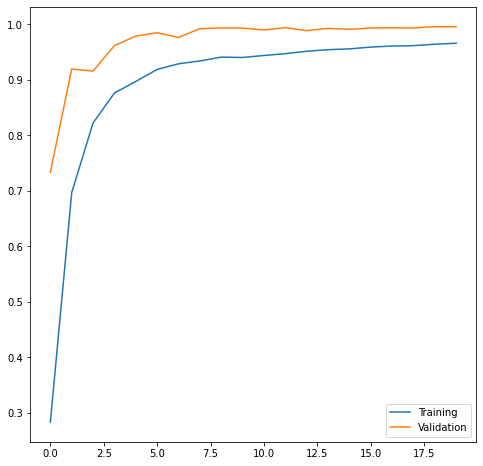

In [19]:
plt.figure(figsize=(8, 8))
plt.plot(logs_cnn.recall, label = "Training")
plt.plot(logs_cnn.val_recall, label = "Validation")
plt.legend()

In [20]:
cnn.evaluate(test_ds)

1710/1710 [==============================] - 10s 6ms/step - loss: 0.0142 - accuracy: 0.9950 - precision: 0.9563 - recall: 0.9965 - auc: 0.9998


[0.014191347174346447,
 0.995037853717804,
 0.9563409686088562,
 0.9964798092842102,
 0.9997533559799194]

In [21]:
cnn.evaluate(train_val_ds)

15389/15389 [==============================] - 94s 6ms/step - loss: 0.0093 - accuracy: 0.9968 - precision: 0.9710 - recall: 0.9986 - auc: 0.9999


[0.009310838766396046,
 0.9968422055244446,
 0.9709978103637695,
 0.99863600730896,
 0.999893307685852]

In [22]:
cnn.save_weights("cnn2.h5")

In [23]:
logs_cnn.to_csv("curves2.csv", index=False)